# FIVO in (Gaussian) LDS Notebook


In [1]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
from jax import random as jr
from copy import deepcopy as dc
from tqdm.notebook import tqdm

# Import some ssm stuff.
from ssm.utils import Verbosity, random_rotation, possibly_disable_jit
from ssm.lds.models import GaussianLDS
import ssm.nn_util as nn_util
from ssm.inference.smc import smc, _plot_single_sweep
import ssm.utils as utils
import ssm.inference.fivo as fivo

# Set the default verbosity.
default_verbosity = Verbosity.DEBUG

# 1. Create Gaussian LDS, Observed Data and Helper Functions.

#### There is quite a lot to set up for this, so we will define some helper functions to abstract and modularize it.

In [2]:
def lds_define_true_model_and_data(key):
    """
    Set up the true model and sample some data from it.
    """
    latent_dim = 3
    emissions_dim = 5
    num_trials = 1000
    num_timesteps = 100

    # Create a more reasonable emission scale.
    transition_scale_tril = 0.1 * np.eye(latent_dim)
    emission_scale_tril = 0.5 * np.eye(emissions_dim)

    # Create the true model.
    key, subkey = jr.split(key)
    true_dynamics_weights = random_rotation(subkey, latent_dim, theta=np.pi / 10)
    true_model = GaussianLDS(num_latent_dims=latent_dim,
                             num_emission_dims=emissions_dim,
                             seed=subkey,
                             dynamics_scale_tril=transition_scale_tril,
                             dynamics_weights=true_dynamics_weights,
                             emission_scale_tril=emission_scale_tril)

    # Sample some data.
    key, subkey = jr.split(key)
    true_states, dataset = true_model.sample(key=subkey, num_steps=num_timesteps, num_samples=num_trials)

    return true_model, true_states, dataset


In [3]:
def lds_define_test_model(subkey, true_model, ):
    """
    Set up the model that we are going to test.
    
    This also defines the model parameters that we are going to learn by defining `free_parameters`, 
    and the function `rebuild_model_fn` that takes the free parameters in and returns a model 
    where the values of the free parameters have been updated.
    """
    
    # Define the parameter names that we are going to learn.
    # This has to be a tuple of strings that index which args we will pull out.
    free_parameters = ('dynamics_weights', )

    # Generate a model to use.
    default_model = GaussianLDS(num_latent_dims=true_model.latent_dim,
                                num_emission_dims=true_model.emissions_shape[0],
                                dynamics_scale_tril=true_model._dynamics.scale_tril,
                                emission_weights=true_model.emissions_matrix,
                                emission_scale_tril=true_model._emissions.scale_tril,
                                seed=subkey)

    # Close over the free parameters we have elected to learn.
    get_free_model_params_fn = lambda _model: fivo.get_model_params_fn(_model, free_parameters)

    # Close over rebuilding the model.
    rebuild_model_fn = lambda _params: fivo.rebuild_model_fn(_params, default_model)

    return default_model, get_free_model_params_fn, rebuild_model_fn

In [4]:
def lds_define_proposal(subkey, model, dataset):
    """
    Set up the proposal we are going to learn.
    
    We will define a proposal family, the parameters, and a function `rebuild_prop_fn` which
    takes in just the parameters (and has closed over the proposal family) and return a 
    function that when called calls the proposal.
    
    If `proposal_structure = None`, then the behaviour defaults to that of the BPF.
    """
    
    proposal_structure = None  # 'RESQ'         # {None/'BOOTSTRAP', 'RESQ', 'DIRECT', }

    if (proposal_structure is None) or (proposal_structure == 'BOOTSTRAP'):
        _empty_rebuild = lambda *args: None
        return None, None, _empty_rebuild

    # Define the proposal that we will use.
    # Stock proposal input form is (dataset, model, particles, t, p_dist, q_state).
    dummy_particles = model.initial_distribution().sample(seed=jr.PRNGKey(0), sample_shape=(2,), )
    dummy_p_dist = model.dynamics_distribution(dummy_particles)
    stock_proposal_input_without_q_state = (dataset[0], model, dummy_particles[0], 0, dummy_p_dist)
    dummy_proposal_output = nn_util.vectorize_pytree(np.ones((model.latent_dim,)), )

    # Define the proposal itself.
    proposal = proposals.IndependentGaussianProposal(n_proposals=1,
                                                     stock_proposal_input_without_q_state=stock_proposal_input_without_q_state,
                                                     dummy_output=dummy_proposal_output)
    proposal_params = proposal.init(subkey)

    # Return a function that we can call with just the parameters as an argument to return a new closed proposal.
    rebuild_prop_fn = proposals.rebuild_proposal(proposal, proposal_structure)
    return proposal, proposal_params, rebuild_prop_fn

In [5]:

def lds_do_print(_step, pred_lml, true_model, true_lml, opt, em_log_marginal_likelihood=None):
    """
    Do menial print stuff.
    """

    _str = 'Step: {: >5d},  True Neg-LML: {: >8.3f},  Pred Neg-LML: {: >8.3f}'.format(_step, true_lml, pred_lml)
    if em_log_marginal_likelihood is not None:
        _str += '  EM Neg-LML: {: >8.3f}'.format(em_log_marginal_likelihood)

    print(_str)
    print('\tTrue: dynamics:  ', ' '.join(['{: >7.2f}'.format(_s) for _s in true_model.dynamics_matrix.flatten()]))
    print('\tPred: dynamics:  ', ' '.join(['{: >7.2f}'.format(_s) for _s in opt[0].target[0].flatten()]))
    print()

#### Now we will call each of these functions.

In [6]:
key = jr.PRNGKey(1)

# Define the true model.
key, subkey = jr.split(key)
true_model, true_states, dataset = lds_define_true_model_and_data(subkey)

# Now define a model to test.
key, subkey = jax.random.split(key)
model, get_model_free_params, rebuild_model_fn = lds_define_test_model(subkey, true_model)

# Define the proposal.
key, subkey = jr.split(key)
proposal, proposal_params, rebuild_prop_fn = lds_define_proposal(subkey, model, dataset)

# 2. Build up the FIVO scripts.

In [7]:
# Define the FIVO parameters.
USE_SGR = True
num_particles = 100
opt_steps = 5000
datasets_per_batch = 8

# Misc other parameters.
dset_to_plot = 2
num_val_datasets = 100

#### Build out the optimizer to store the parameters.

In [8]:
# Build up the optimizer.
opt = fivo.define_optimizer(p_params=get_model_free_params(model),
                            q_params=proposal_params)

#### Now we need to build up the SMC/FIVO functions so that we can call them effectively.

In [9]:
# Close over constant parameters.
do_fivo_sweep_closed = lambda _key, _params, _num_particles, _num_datasets, _datasets: \
    fivo.do_fivo_sweep(_params,
                       _key,
                       rebuild_model_fn,
                       rebuild_prop_fn,
                       _datasets,
                       _num_particles,
                       **{'use_stop_gradient_resampling': USE_SGR})

# Jit this badboy.
do_fivo_sweep_jitted = \
    jax.jit(do_fivo_sweep_closed, static_argnums=(2, 3))

# Convert into value and grad.
do_fivo_sweep_val_and_grad = \
    jax.value_and_grad(do_fivo_sweep_jitted, argnums=1, has_aux=True)

# 3. Do Initial Validation and Scoring.

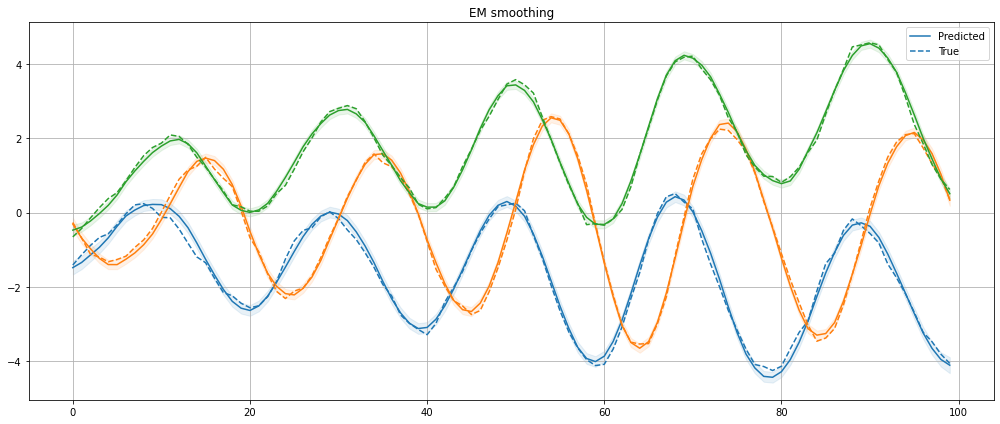

In [ ]:

def initial_validation(key, true_model, dataset, true_states, opt, _do_fivo_sweep_jitted, _num_particles=5000, _dset_to_plot=0):
    """
    Do a test of the true model and the initialized model.
    """
    true_lml, em_log_marginal_likelihood = 0.0, 0.0

    # Test against EM (which for the LDS is exact).
    em_posterior = jax.vmap(true_model.e_step)(dataset)
    em_log_marginal_likelihood = true_model.marginal_likelihood(dataset, posterior=em_posterior)
    em_log_marginal_likelihood = - utils.lexp(em_log_marginal_likelihood)
    sweep_em_mean = em_posterior.mean()[_dset_to_plot]
    sweep_em_sds = np.sqrt(np.asarray([[np.diag(__k) for __k in _k] for _k in em_posterior.covariance()]))[_dset_to_plot]
    sweep_em_statistics = (sweep_em_mean, sweep_em_mean - sweep_em_sds, sweep_em_mean + sweep_em_sds)
    _plot_single_sweep(sweep_em_statistics, true_states[_dset_to_plot],
                       tag='EM smoothing', preprocessed=True, _obs=dataset[_dset_to_plot])

    # Test SMC in the true model..
    key, subkey = jr.split(key)
    smc_posterior = smc(subkey, true_model, dataset, num_particles=_num_particles)
    true_lml = - utils.lexp(smc_posterior.log_normalizer)
    _plot_single_sweep(smc_posterior[_dset_to_plot].filtering_particles,
                       true_states[_dset_to_plot],
                       tag='True BPF Filtering.',
                       _obs=dataset[_dset_to_plot])
    key, subkey = jr.split(key)
    _plot_single_sweep(smc_posterior[_dset_to_plot].sample(sample_shape=(_num_particles,), seed=subkey),
                       true_states[_dset_to_plot],
                       tag='True BPF Smoothing.',
                       _obs=dataset[_dset_to_plot])

    # Test SMC in the initial model.
    initial_params = dc(fivo.get_params_from_opt(opt))
    key, subkey = jr.split(key)
    initial_lml, sweep_posteriors = _do_fivo_sweep_jitted(subkey, fivo.get_params_from_opt(opt),
                                                          _num_particles=_num_particles,
                                                          _num_datasets=len(dataset),
                                                          _datasets=dataset)
    filt_fig = _plot_single_sweep(sweep_posteriors[_dset_to_plot].filtering_particles,
                                  true_states[_dset_to_plot],
                                  tag='Initial Filtering.',
                                  _obs=dataset[_dset_to_plot])
    key, subkey = jr.split(key)
    sweep_fig = _plot_single_sweep(sweep_posteriors[_dset_to_plot].sample(sample_shape=(_num_particles,), seed=subkey),
                                   true_states[_dset_to_plot],
                                   tag='Initial Smoothing.',
                                   _obs=dataset[_dset_to_plot])

    # Do some print.
    lds_do_print(0, initial_lml, true_model, true_lml, opt, em_log_marginal_likelihood)
    return true_lml, em_log_marginal_likelihood, sweep_fig, filt_fig


# Test the initial models.
true_lml, em_log_marginal_likelihood, sweep_fig, filt_fig = \
    initial_validation(key, true_model, dataset[:num_val_datasets], true_states, opt, do_fivo_sweep_jitted,
                       _num_particles=5000, _dset_to_plot=dset_to_plot)

# 4. Do FIVO!

In [ ]:
# Define some storage.
param_hist = [[], []]  # Model, proposal.
loss_hist = []
param_figures = [None, None]  # Model, proposal.


def log_params(_param_hist, _cur_params):
    """
    Short helper for logging the parameter values.
    """

    if _cur_params[0] is not None:
        _param_hist[0].append(_cur_params[0]._asdict())
    else:
        _param_hist[0].append(None)

    if _cur_params[1] is not None:
        _p = _cur_params[1]['params']._dict
        _p_flat = {}
        for _ko in _p.keys():
            for _ki in _p[_ko].keys():
                _k = _ko + '_' + _ki
                _p_flat[_k] = _p[_ko][_ki]
        _param_hist[1].append(_p_flat)
    else:
        _param_hist[1].append(None)

    return _param_hist

In [ ]:
# Main training loop.
for _step in tqdm(range(opt_steps)):

    # Batch the data.
    key, subkey = jr.split(key)
    idx = jr.randint(key=subkey, shape=(datasets_per_batch, ), minval=0, maxval=len(dataset))
    batched_dataset = dataset.at[idx].get()

    # Do the sweep and compute the gradient.
    key, subkey = jr.split(key)
    cur_params = dc(fivo.get_params_from_opt(opt))
    (pred_lml, smc_posteriors), grad = do_fivo_sweep_val_and_grad(subkey,
                                                                  fivo.get_params_from_opt(opt),
                                                                  num_particles,
                                                                  len(batched_dataset),
                                                                  batched_dataset)

    # Apply the gradient update.
    opt = fivo.apply_gradient(grad, opt, )

    # Log.
    loss_hist.append(dc(pred_lml))
    param_hist = log_params(param_hist, cur_params)

    # Do some validation and give some output.
    coldstart = 2
    if (_step % 1000 == 0) or (_step < coldstart):
        pred_lml_to_print = pred_lml

        if _step > coldstart:
            key, subkey = jr.split(key)
            pred_lml_to_print, pred_sweep = do_fivo_sweep_jitted(subkey, fivo.get_params_from_opt(opt),
                                                                 _num_particles=5000,
                                                                 _num_datasets=len(dataset[:num_val_datasets]),
                                                                 _datasets=dataset[:num_val_datasets])
            filt_fig = _plot_single_sweep(pred_sweep[dset_to_plot].filtering_particles,
                                          true_states[dset_to_plot],
                                          tag='{} Filtering.'.format(_step),
                                          fig=filt_fig,
                                          _obs=dataset[dset_to_plot])
            sweep_fig = _plot_single_sweep(pred_sweep[dset_to_plot].sample(sample_shape=(num_particles,), seed=subkey),
                                           true_states[dset_to_plot],
                                           tag='{} Smoothing.'.format(_step),
                                           fig=sweep_fig,
                                           _obs=dataset[dset_to_plot])

        lds_do_print(_step, pred_lml_to_print, true_model, true_lml, opt, em_log_marginal_likelihood)


---
---